## _Target Spam Words and Patterns_
***
DESCRIPTION

How to build a spam filter for text messages using Natural Language Processing.

We'll make use of some of the NLP concepts and combine them with machine learning to build a spam filter for SMS text messages.      




## _Import Libraries and Load the Data_

In [32]:
#import the libraries
import os 
import sys
import io
import pickle
from sys import path
assert sys.version_info >= (3,5)

#data manipulation
import pandas as pd
import numpy as np

#visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.core.display import display
from IPython.core.display import HTML

#consistent sized plot
from pylab import rcParams
rcParams['figure.figsize'] = 12,5
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
rcParams['axes.labelsize'] = 12

#display options for dataframe
pd.options.display.max_columns = None

#text processing
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import SnowballStemmer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from fuzzywuzzy import process
from fuzzywuzzy import fuzz

#text feature engineering
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

#models
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC

#regular expressions
import re

#string operations
import string
from string import punctuation
from string import digits

#compute articles similarity
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

#for file extraction
from zipfile import ZipFile

#ignore warnings
import warnings
warnings.filterwarnings(action='ignore',message='')

In [2]:
# untar the file
filename = '1599823601_smsspamcollection.zip'
with ZipFile(filename, 'r') as zip:
    #list the contents of the zip file
    zip.printdir()
    #extract the contents of the zip file
    print('extracting contents, please wait ...')
    zip.extractall()
    print('done, your files have been unzipped !')

File Name                                             Modified             Size
SMSSpamCollection.txt                          2019-09-15 01:40:06       477907
extracting contents, please wait ...
done, your files have been unzipped !


In [3]:
# load the spam collection sms file
sms =  pd.read_table('SMSSpamCollection.txt',names=['label','message'])
sms.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
sms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [5]:
sms['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

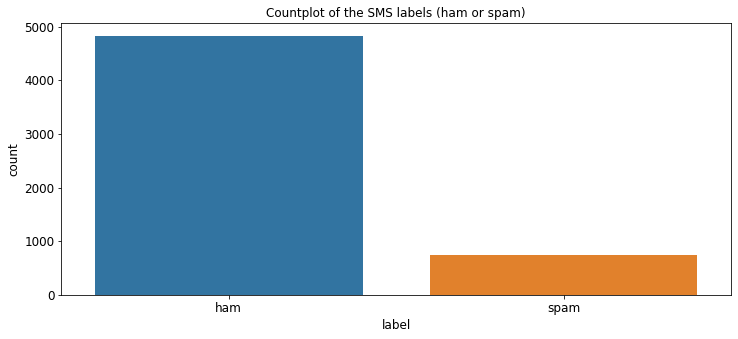

In [6]:
#countplot of the categories of sentiments
sns.countplot(sms['label'])
plt.title('Countplot of the SMS labels (ham or spam)')
plt.show()

- <b> _The data is highly imbalanced. There are a lot more ham messages than the spam messages_ </b>

In [7]:
sms.isna().sum()

label      0
message    0
dtype: int64

In [8]:
#check for any empty string
blanks = []
for idx,rev,lab in sms.itertuples():
    if type(rev) == 'str':
        if rev.isspace():
            blanks.append(idx)
print(blanks)  

[]


- <b> _There are no blank messages in the dataset. Also, there are no null or missing values in the dataset_ </b>

## _Split the dataset into train and test set_

In [9]:
X = sms.drop('label',axis=1)
y = sms['label']
test_size = 0.3
random_state = 42
#split the dataset
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=test_size,random_state=random_state,stratify=sms['label'])
X_train.shape,X_test.shape

((3900, 1), (1672, 1))

## _Text Preprocessing - Cleaning & Preparing for Modeling_

In [10]:
def simplify(text):
    '''Function to handle the diacritics in the text'''
    import unicodedata
    try:
        text = unicode(text, 'utf-8')
    except NameError:
        pass
    text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode("utf-8")
    return str(text)

In [11]:
stemmer = PorterStemmer()
def text_cleaning(text):
    '''Function to clean the text'''
    #convert to lower case
    text = text.lower()
    #remove the email address
    text = text.replace(r'[a-zA-z0-9._]+@[a-zA-z0-9._]+','emailaddr')
    #replace the URL's
    text = text.replace(r'(http[s]?\S+)|(\w+\.[a-zA-Z]{2,4}\S*)','httpaddr')
    #replace currency symbol with moneysymb
    text = text.replace(r'£|\$', 'moneysymb')
    # Replace phone numbers with 'phonenumbr'
    text = text.replace(r'\b(\+\d{1,2}\s)?\d?[\-(.]?\d{3}\)?[\s.-]?\d{3}[\s.-]?\d{4}\b','phonenumbr')
    #remove the ip address
    text = text.replace(r'((2[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.|$)){4}','')
    #remove the user handles
    text = text.replace(r'@\w+','')
    #remove the string punctuation
    text = ' '.join([txt for txt in word_tokenize(text) if txt not in string.punctuation])
    #replace the digits from the text with numbr
    text = text.replace(r'\d','numbr')    
    #remove all non alphabetical characters
    text = ' '.join([txt for txt in word_tokenize(text) if txt.isalpha()])
    #replace multiple white space with a single one
    text = text.replace(r'\s+', ' ')
    #remove the leading and trailing whitespaces
    text = text.replace(r'^\s+|\s+?$', '')
    #remove the stop words
    text = ' '.join([txt for txt in word_tokenize(text) if txt not in stopwords.words('english')])
    #apply stemmer
    text = ' '.join([stemmer.stem(txt) for txt in word_tokenize(text)])
    
    #return the cleaned text
    return text

In [12]:
'''
Clean the text values in train and test
'''
preprocesses = [simplify,text_cleaning]

for preprocess in preprocesses:
    X_train['message'] = X_train['message'].apply(preprocess)
    X_test['message'] = X_test['message'].apply(preprocess)

In [13]:
# Construct a design matrix using an n-gram model and a tf-idf statistics
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
counts = vectorizer.fit_transform(X_train['message'])
vocab = vectorizer.vocabulary_

In [14]:
test_counts = vectorizer.transform(X_test['message'])

In [15]:
#label encode the target features
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

In [16]:
# Train SVM with a linear kernel on the training set
clf = LinearSVC(loss='hinge')
clf.fit(counts, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
          penalty='l2', random_state=None, tol=0.0001, verbose=0)

In [17]:
train_predictions = clf.predict(counts)

In [18]:
test_predictions = clf.predict(test_counts)

In [19]:
print('Accuracy Score on the Train and Test Set')
print('Train Accuracy = {}'.format(accuracy_score(y_train,train_predictions)))
print('Test Accuracy = {}'.format(accuracy_score(y_test,test_predictions)))

Accuracy Score on the Train and Test Set
Train Accuracy = 0.9974358974358974
Test Accuracy = 0.9844497607655502


In [20]:
print('Classification Report on Test Set')
print(classification_report(y_test,test_predictions))

Classification Report on Test Set
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1448
           1       0.97      0.91      0.94       224

    accuracy                           0.98      1672
   macro avg       0.98      0.95      0.97      1672
weighted avg       0.98      0.98      0.98      1672



In [21]:
print('F-1 score on the test set')
print('Test Set F1 Score = {}'.format(f1_score(y_test,test_predictions)))

F-1 score on the test set
Test Set F1 Score = 0.9400921658986174


In [22]:
print('Confusion Matrix on the Test Set')
print(confusion_matrix(y_test,test_predictions))

Confusion Matrix on the Test Set
[[1442    6]
 [  20  204]]


In [23]:
# Display a confusion matrix

pd.DataFrame(confusion_matrix(y_test,test_predictions),index=[['actual', 'actual'], ['spam', 'ham']],
             columns=[['predicted', 'predicted'], ['spam', 'ham']])

predicted     
                 spam  ham
actual spam      1442    6
       ham         20  204

## _Model Fine Tuning_

In [24]:
# select 10 different sizes of the entire training dataset. The test set will still be kept separate an an unseen data
raw_text = X_train['message']
sample_space = np.linspace(500,len(raw_text)*.80,10,dtype='int')

# Compute learning curves without regularization for the SVM model
train_size,train_scores,valid_scores = learning_curve(estimator=LinearSVC(loss='hinge',C=1e10),
                                                      X=counts,y=y_train,
                                                      train_sizes=sample_space,
                                                      cv=StratifiedShuffleSplit(n_splits=10,test_size=0.2,random_state=42),
                                                      scoring='f1',
                                                      n_jobs=-1)

In [25]:
train_size

array([ 500,  791, 1082, 1373, 1664, 1955, 2246, 2537, 2828, 3120])

In [26]:
#check the train scores
train_scores

array([[1.        , 1.        , 1.        , 0.99236641, 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 0.99530516, 1.        ,
        1.        , 1.        , 1.        , 1.        , 0.99415205],
       [1.        , 1.        , 1.        , 0.99646643, 1.        ,
        1.        , 1.        , 1.        , 1.        , 0.99616858],
       [1.        , 1.        , 1.        , 0.99726027, 1.        ,
        1.        , 1.        , 1.        , 1.        , 0.99711816],
       [1.        , 1.        , 1.        , 0.99779249, 1.        ,
        1.        , 1.        , 1.        , 0.99788584, 0.99765808],
       [0.99796334, 0.99815157, 1.        , 0.99815838, 1.        ,
        0.99802761, 1.        , 1.        , 0.99815838, 0.99800399],
       [0.9982669 , 0.99836334, 1.        , 0.99835796, 1.        ,
        0.99833055, 1.        , 1.        , 0.99838969, 0.9981982 ],
       [0.99848714, 0.99854015, 1.       

In [27]:
#checl the test scores 
valid_scores

array([[0.59060403, 0.5106383 , 0.45588235, 0.83333333, 0.61437908,
        0.52413793, 0.64516129, 0.62745098, 0.61437908, 0.34375   ],
       [0.75739645, 0.7037037 , 0.65384615, 0.87700535, 0.69135802,
        0.65408805, 0.72727273, 0.79310345, 0.74117647, 0.68322981],
       [0.82681564, 0.79310345, 0.7195122 , 0.85869565, 0.74251497,
        0.70731707, 0.76023392, 0.85405405, 0.82417582, 0.74418605],
       [0.82022472, 0.83977901, 0.79545455, 0.86021505, 0.77906977,
        0.77456647, 0.7816092 , 0.87096774, 0.84946237, 0.79329609],
       [0.86486486, 0.84615385, 0.80225989, 0.87830688, 0.79310345,
        0.82872928, 0.79545455, 0.90052356, 0.87046632, 0.82608696],
       [0.91836735, 0.89119171, 0.81564246, 0.90052356, 0.83977901,
        0.86170213, 0.80681818, 0.91282051, 0.88541667, 0.84491979],
       [0.90625   , 0.90816327, 0.82222222, 0.90052356, 0.85869565,
        0.87958115, 0.82022472, 0.94      , 0.88082902, 0.85106383],
       [0.90721649, 0.9015544 , 0.8478260

In [28]:
def make_tidy(sample_space, train_scores, valid_scores):
    # Join train_scores and valid_scores, and label with sample_space
    messy_format = pd.DataFrame(np.stack((sample_space, train_scores.mean(axis=1),valid_scores.mean(axis=1)), axis=1),
                                columns=['# of training examples', 'Training set', 'Validation set'])
     # Re-structure into into tidy format
    return pd.melt(messy_format,id_vars='# of training examples',value_vars=['Training set', 'Validation set'],
                   var_name='Scores',value_name='F1 score')

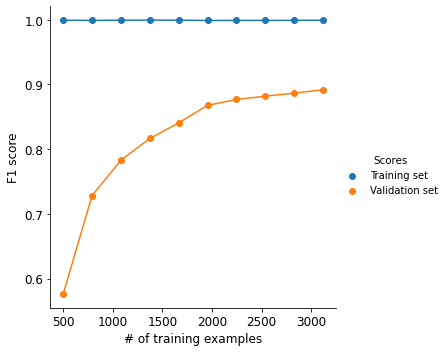

In [29]:
# Initialize a FacetGrid object using the table of scores and facet on the type of score
g = sns.FacetGrid(make_tidy(sample_space, train_scores, valid_scores), hue='Scores', size=5)
# Plot the learning curves and add a legend
g.map(plt.scatter, '# of training examples', 'F1 score')
g.map(plt.plot, '# of training examples', 'F1 score').add_legend()
plt.show()

In [37]:
''' Grid Search for the best hyperparameter '''
from scipy.stats import loguniform
space = dict()
space['penalty'] = ['l1', 'l2', 'elasticnet']
space['loss'] = ['squared_hinge','hinge']
space['C'] = [1e10,100]
print(space)

{'penalty': ['l1', 'l2', 'elasticnet'], 'loss': ['squared_hinge', 'hinge'], 'C': [10000000000.0, 100]}


In [63]:
clf = LinearSVC()
folds = StratifiedKFold(n_splits=10,random_state=random_state)
grid_search = GridSearchCV(estimator=clf,param_grid=space,scoring='f1',
                           n_jobs=-1, cv=folds)
grid_result = grid_search.fit(counts,y_train)

In [64]:
grid_result.best_params_

{'C': 100, 'loss': 'hinge', 'penalty': 'l2'}

In [ ]:
#clf = LinearSVC(loss='hinge',penalty='l2',C=100)
clf = grid_result.best_estimator_
clf.fit(counts,y_train)
train_predictions = clf.predict(counts)
test_predictions = clf.predict(test_counts)

In [71]:
print('Accuracy Score on the Train and Test Set')
print('Train Accuracy = {}'.format(accuracy_score(y_train,train_predictions)))
print('Test Accuracy = {}'.format(accuracy_score(y_test,test_predictions)))

Accuracy Score on the Train and Test Set
Train Accuracy = 0.9997435897435898
Test Accuracy = 0.9826555023923444


In [72]:
print('Classification Report on Test Set')
print(classification_report(y_test,test_predictions))

Classification Report on Test Set
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1448
           1       0.95      0.92      0.93       224

    accuracy                           0.98      1672
   macro avg       0.97      0.96      0.96      1672
weighted avg       0.98      0.98      0.98      1672



- <b> _Grid search fine tuned hyperparameters does not outperform the f1 score achieved using the base model. Other combinations of hyper parameters can also be tried_ </b>

In [73]:
# Display a confusion matrix

pd.DataFrame(confusion_matrix(y_test,test_predictions),index=[['actual', 'actual'], ['spam', 'ham']],
             columns=[['predicted', 'predicted'], ['spam', 'ham']])

predicted     
                 spam  ham
actual spam      1436   12
       ham         17  207

In [74]:
# Display the features with the highest weights in the SVM model
pd.Series(clf.coef_.T.ravel(),index=vectorizer.get_feature_names()).sort_values(ascending=False)[:20]

txt          3.523728
claim        2.539601
servic       2.309778
repli        2.289231
mobil        2.195162
prize        1.999999
cost         1.999958
stop         1.950816
rington      1.898867
http         1.858149
text         1.806301
tone         1.725355
uk           1.707445
collect      1.665023
lost help    1.650025
award        1.617781
new          1.588394
video        1.558271
bid          1.547377
order        1.540384
dtype: float64

In [87]:
# to finish up, let's write up a function that'll decide whether a string is spam or not, and apply it on the hypothetical message from earlier.

def spam_filter(message):
    '''Classify whether spam or ham for an unseen text message'''
    text = simplify(message)
    text_clean = text_cleaning(text)
    if clf.predict(vectorizer.transform([text_clean])):
        return 'spam'
    else:
        return 'not spam'   

# spam_filter(example)

spam_filter('Ohhh, but those are the best kind of foods')

'not spam'

In [90]:
spam_filter('You have won 10 million as an award. Send me your personal details on this number 898876446 or http://www.prd.com')

'spam'